# scVI bm CITEseq







## Single study normalization

In [1]:
import tempfile
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import seaborn as sns
import torch
import numpy as np
import time
from scipy.stats import pearsonr
import plotnine as p9

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ADT_data = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/ADT.h5ad')
RNA_data = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/RNA.h5ad')

In [3]:
print(ADT_data)

AnnData object with n_obs × n_vars = 30672 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
    uns: 'X_name'


In [4]:
RNA_data.layers["counts"] = RNA_data.X.copy()
print(RNA_data)

AnnData object with n_obs × n_vars = 30672 × 8000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
    uns: 'X_name'
    layers: 'counts'


#### Now we create a mudata object with muon. This is the equivalent of MultiAssayExperiment or Seurat obj in R, where multiple omics can be stored in one object.

In [5]:
mdata = muon.MuData({'rna': RNA_data, 'adt': ADT_data})

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [6]:
print(mdata)

MuData object with n_obs × n_vars = 30672 × 8025
  2 modalities
    rna:	30672 x 8000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
      uns:	'X_name'
      layers:	'counts'
    adt:	30672 x 25
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
      uns:	'X_name'


In [7]:
scvi.settings.seed = 0

[rank: 0] Global seed set to 0


In [8]:
## Use scanpy to filter highly variable genes

sc.pp.highly_variable_genes(
    adata = mdata.mod['rna'],
    layer = 'counts', 
    n_top_genes = 4000,
    flavor = 'seurat_v3',
    batch_key= 'donor')

# Save filtered transcriptome as extra dimension
mdata.mod['filtered_transcriptome'] = mdata.mod['rna'][:, mdata.mod['rna'].var['highly_variable']].copy()
mdata.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [9]:
mdata.mod['rna'].var['highly_variable']

SAMD11          True
HES4            True
ISG15           True
TNFRSF18        True
TNFRSF4         True
               ...  
AP000223.42    False
DSCR9           True
AP001626.2      True
AP001046.5     False
AC004556.1      True
Name: highly_variable, Length: 8000, dtype: bool

In [10]:
mdata.mod['adt'].X = mdata.mod['adt'].X.toarray()
# Convert to RNA csr matrix for faster training
mdata.mod['rna'].X = mdata.mod['rna'].X.tocsr()
mdata.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [11]:
scvi.model.TOTALVI.setup_mudata(mdata = mdata, 
                                rna_layer = 'counts', 
                                protein_layer= None, 
                                batch_key= 'donor' , 
                                modalities= {"rna_layer":'filtered_transcriptome',
                                             'protein_layer':'adt',
                                             'batch_key':'rna'})

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.


In [12]:
model = scvi.model.TOTALVI(mdata, latent_distribution= 'normal')

INFO     Computing empirical prior initialization for protein background.                                          


In [13]:
start_time = time.time()
model.train()
end_time = time.time()
training_duration = end_time - start_time
mdata.uns['runtime'] = training_duration

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 261/261: 100%|██████████| 261/261 [41:31<00:00,  9.62s/it, v_num=1, train_loss_step=462, train_loss_epoch=448]

`Trainer.fit` stopped: `max_epochs=261` reached.


Epoch 261/261: 100%|██████████| 261/261 [41:31<00:00,  9.55s/it, v_num=1, train_loss_step=462, train_loss_epoch=448]


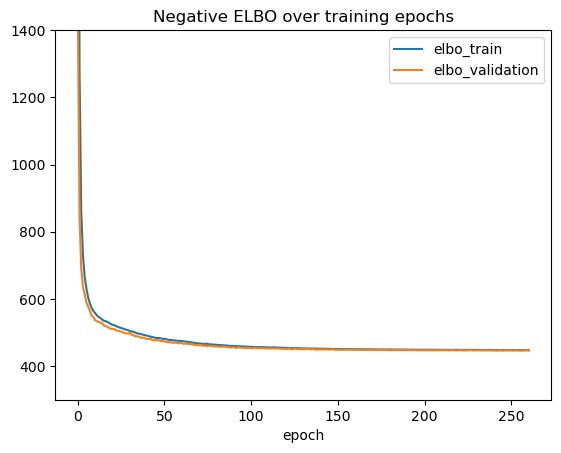

In [14]:
fig, ax = plt.subplots(1, 1)
model.history["elbo_train"].plot(ax=ax, label="train")
model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(300, 1400))
ax.legend()

In [15]:
# get totalVI's latent dimensions 
mdata.mod['filtered_transcriptome'].obsm['totalVI_latent_dims'] = model.get_latent_representation()
rna_normalized, protein_normalized = model.get_normalized_expression()
mdata.mod['adt'].layers['adt_normalized'] = protein_normalized
mdata.mod['adt'].uns['totalVI_runtime'] = training_duration
mdata.mod['filtered_transcriptome'].layers['rna_normalized'] = rna_normalized
mdata.mod['filtered_transcriptome'].uns['totalVI_runtime'] = training_duration
mdata.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [16]:
# Check if anything looks off
mdata

MuData object with n_obs × n_vars = 30672 × 12025
  obs:	'_scvi_labels'
  uns:	'_scvi_uuid', '_scvi_manager_uuid', 'runtime'
  3 modalities
    rna:	30672 x 8000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize', '_scvi_batch'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'X_name', 'hvg'
      layers:	'counts'
    adt:	30672 x 25
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize', '_scvi_batch'
      uns:	'X_name', 'totalVI_runtime'
      layers:	'adt_normalized'
    filtered_transcriptome:	30672 x 4000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'log2_rna_libsize', 'log2_adt_libsize'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'X_name', 'hvg', 'totalVI_runtime'
      obsm:	'totalVI_latent_dims'
      layers:	'counts', 'rna_normalized'

In [17]:
# Save the muon object as h5 so we can load it into R
#mdata.write_h5mu('/vast/scratch/users/liu.ne/totalVI_mudata')
mdata.mod['adt'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_adt.h5ad')
mdata.mod['filtered_transcriptome'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_rna.h5ad')

## Multi study normalization

In [40]:
# Load the data
merged_ADT = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/ADT_merged.h5ad')
merged_RNA = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/RNA_merged.h5ad')

In [41]:
merged_RNA

AnnData object with n_obs × n_vars = 43837 × 8103
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'study', 'supplied_celltype_l2', 'celltype.l1_with_transfer', 'celltype.l2_with_transfer', 'nCount_AB', 'nFeature_AB', 'percent.mt', 'nCount_BOTH', 'nFeature_BOTH', 'ClusterID', 'Batch', 'ct', 'cDC', 'B.cells', 'Myelocytes', 'Erythroid', 'Megakaryocte', 'transferred_celltype.l1', 'transferred_celltype.l2', 'log2_libsize', 'nCount_ADT', 'nFeature_ADT', 'log2_adt_libsize', 'RNA.weight', 'ADT.weight', 'wnn_clusters', 'seurat_clusters', 'rna_clusters', 'adt_clusters', 'log2_rna_libsize'
    uns: 'X_name'

In [44]:
merged_RNA.layers["counts"] = merged_RNA.X.copy()
merged_data = muon.MuData({'rna': merged_RNA, 'adt': merged_ADT})

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [46]:
## Use scanpy to filter highly variable genes

sc.pp.highly_variable_genes(
    adata = merged_data.mod['rna'],
    layer = 'counts', 
    n_top_genes = 4000,
    flavor = 'seurat_v3',
    batch_key= 'study')

# Save filtered transcriptome as extra dimension
merged_data.mod['filtered_transcriptome'] = merged_data.mod['rna'][:, merged_data.mod['rna'].var['highly_variable']].copy()
merged_data.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [47]:
merged_data.mod['adt'].X = merged_data.mod['adt'].X.toarray()
# Convert to RNA csr matrix for faster training
merged_data.mod['rna'].X = merged_data.mod['rna'].X.tocsr()
merged_data.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [48]:
merged_data

MuData object with n_obs × n_vars = 43837 × 12119
  3 modalities
    rna:	43837 x 8103
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'study', 'supplied_celltype_l2', 'celltype.l1_with_transfer', 'celltype.l2_with_transfer', 'nCount_AB', 'nFeature_AB', 'percent.mt', 'nCount_BOTH', 'nFeature_BOTH', 'ClusterID', 'Batch', 'ct', 'cDC', 'B.cells', 'Myelocytes', 'Erythroid', 'Megakaryocte', 'transferred_celltype.l1', 'transferred_celltype.l2', 'log2_libsize', 'nCount_ADT', 'nFeature_ADT', 'log2_adt_libsize', 'RNA.weight', 'ADT.weight', 'wnn_clusters', 'seurat_clusters', 'rna_clusters', 'adt_clusters', 'log2_rna_libsize'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'X_name', 'hvg'
      layers:	'counts'
    adt:	43837 x 16
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'study', 'supplied_celltype_l2', 'celltype.l1_with_transfer', 'celltype.l2_with_transfer', 'nCount_AB', 'nFeature_AB', 'percent.mt', 'nCount_BOTH', 'nFeature_BOTH', 'ClusterID', 'Batch', 'ct', 'cDC', 'B.cells', 'Myelocytes', 'Erythroid', 'Megakaryocte', 'transferred_celltype.l1', 'transferred_celltype.l2', 'log2_libsize', 'nCount_ADT', 'nFeature_ADT', 'log2_adt_libsize', 'RNA.weight', 'ADT.weight', 'wnn_clusters', 'seurat_clusters', 'rna_clusters', 'adt_clusters', 'log2_rna_libsize'
      uns:	'X_name'
    filtered_transcriptome:	43837 x 4000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'study', 'supplied_celltype_l2', 'celltype.l1_with_transfer', 'celltype.l2_with_transfer', 'nCount_AB', 'nFeature_AB', 'percent.mt', 'nCount_BOTH', 'nFeature_BOTH', 'ClusterID', 'Batch', 'ct', 'cDC', 'B.cells', 'Myelocytes', 'Erythroid', 'Megakaryocte', 'transferred_celltype.l1', 'transferred_celltype.l2', 'log2_libsize', 'nCount_ADT', 'nFeature_ADT', 'log2_adt_libsize', 'RNA.weight', 'ADT.weight', 'wnn_clusters', 'seurat_clusters', 'rna_clusters', 'adt_clusters', 'log2_rna_libsize'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'X_name', 'hvg'
      layers:	'counts'

In [49]:
scvi.model.TOTALVI.setup_mudata(
    mdata = merged_data,
    rna_layer = 'counts',
    protein_layer= None,
    batch_key= 'study' ,
    modalities= {"rna_layer":'filtered_transcriptome',
                 'protein_layer':'adt',
                 'batch_key':'rna'})

model = scvi.model.TOTALVI(merged_data, latent_distribution= 'normal')


INFO     Computing empirical prior initialization for protein background.                                          


/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.


In [ ]:
start_time = time.time()
model.train()
end_time = time.time()
training_duration = end_time - start_time

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 85/182:  46%|████▌     | 84/182 [29:16<34:06, 20.88s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.4e+3]  

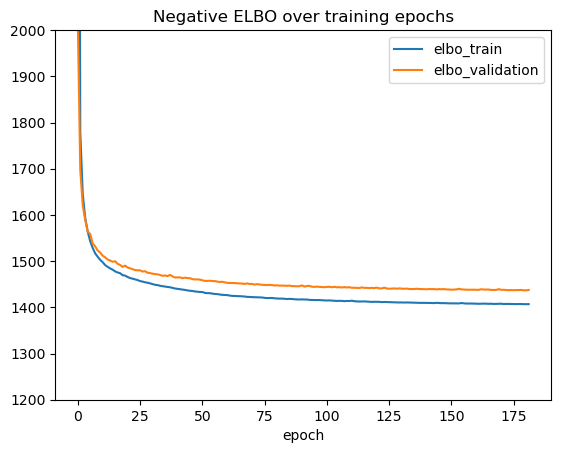

In [64]:
fig, ax = plt.subplots(1, 1)
model.history["elbo_train"].plot(ax=ax, label="train")
model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(1200, 2000))
ax.legend()

In [57]:
# get totalVI's latent dimensions 
merged_data.mod['filtered_transcriptome'].obsm['totalVI_latent_dims'] = model.get_latent_representation()
rna_normalized, protein_normalized = model.get_normalized_expression()
merged_data.mod['adt'].layers['adt_normalized'] = protein_normalized
merged_data.mod['adt'].uns['totalVI_runtime'] = training_duration
merged_data.mod['filtered_transcriptome'].layers['rna_normalized'] = rna_normalized
merged_data.mod['filtered_transcriptome'].uns['totalVI_runtime'] = training_duration
merged_data.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [59]:
# Check if anything looks off
merged_data

MuData object with n_obs × n_vars = 43837 × 12119
  obs:	'_scvi_labels'
  uns:	'_scvi_uuid', '_scvi_manager_uuid'
  3 modalities
    rna:	43837 x 8103
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'study', 'supplied_celltype_l2', 'celltype.l1_with_transfer', 'celltype.l2_with_transfer', 'nCount_AB', 'nFeature_AB', 'percent.mt', 'nCount_BOTH', 'nFeature_BOTH', 'ClusterID', 'Batch', 'ct', 'cDC', 'B.cells', 'Myelocytes', 'Erythroid', 'Megakaryocte', 'transferred_celltype.l1', 'transferred_celltype.l2', 'log2_libsize', 'nCount_ADT', 'nFeature_ADT', 'log2_adt_libsize', 'RNA.weight', 'ADT.weight', 'wnn_clusters', 'seurat_clusters', 'rna_clusters', 'adt_clusters', 'log2_rna_libsize', '_scvi_batch'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'X_name', 'hvg'
      layers:	'counts'
    adt:	43837 x 16
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'study', 'supplied_celltype_l2', 'celltype.l1_with_transfer', 'celltype.l2_with_transfer', 'nCount_AB', 'nFeature_AB', 'percent.mt', 'nCount_BOTH', 'nFeature_BOTH', 'ClusterID', 'Batch', 'ct', 'cDC', 'B.cells', 'Myelocytes', 'Erythroid', 'Megakaryocte', 'transferred_celltype.l1', 'transferred_celltype.l2', 'log2_libsize', 'nCount_ADT', 'nFeature_ADT', 'log2_adt_libsize', 'RNA.weight', 'ADT.weight', 'wnn_clusters', 'seurat_clusters', 'rna_clusters', 'adt_clusters', 'log2_rna_libsize', '_scvi_batch'
      uns:	'X_name', 'totalVI_runtime'
      layers:	'adt_normalized'
    filtered_transcriptome:	43837 x 4000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'study', 'supplied_celltype_l2', 'celltype.l1_with_transfer', 'celltype.l2_with_transfer', 'nCount_AB', 'nFeature_AB', 'percent.mt', 'nCount_BOTH', 'nFeature_BOTH', 'ClusterID', 'Batch', 'ct', 'cDC', 'B.cells', 'Myelocytes', 'Erythroid', 'Megakaryocte', 'transferred_celltype.l1', 'transferred_celltype.l2', 'log2_libsize', 'nCount_ADT', 'nFeature_ADT', 'log2_adt_libsize', 'RNA.weight', 'ADT.weight', 'wnn_clusters', 'seurat_clusters', 'rna_clusters', 'adt_clusters', 'log2_rna_libsize'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'X_name', 'hvg', 'totalVI_runtime'
      obsm:	'totalVI_latent_dims'
      layers:	'counts', 'rna_normalized'

In [60]:
# Save the muon object as h5 so we can load it into R
#mdata.write_h5mu('/vast/scratch/users/liu.ne/totalVI_mudata')
merged_data.mod['adt'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_adt_merged.h5ad')
merged_data.mod['filtered_transcriptome'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_rna_merged.h5ad')

# Kotliarov et al's 54k pbmc influenza dataset

In [2]:
# Load the data
influenza_ADT = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/ADT_influenza.h5ad')
influenza_RNA = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/RNA_influenza.h5ad')

In [7]:
influenza_RNA

AnnData object with n_obs × n_vars = 53201 × 6287
    obs: 'nGene', 'nUMI', 'orig.ident', 'pctMT', 'barcode_check', 'tenx_lane', 'cohort', 'batch', 'hash_maxID', 'hash_secondID', 'hash_margin', 'hto_classification', 'hto_classification_global', 'hash_ID', 'adjmfc.time', 'DEMUXLET.RD.PASS', 'DEMUXLET.N.SNP', 'DMX_GLOBAL_BEST', 'DEMUXLET.BARCODE', 'sample', 'sampleid', 'joint_classification_global', 'dmx_hto_match', 'timepoint', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'sizefactors', 'p3_dist_1', 'p3_dist_2', 'p3_dist_3', 'p3_dist_4', 'K0', 'K1', 'K2', 'K3', 'log2_rna_libsize', 'log2_adt_libsize'
    uns: 'X_name'
    layers: 'counts'

In [10]:
influenza_RNA.layers["counts"] = influenza_RNA.X.copy()
influenza_data = muon.MuData({'rna': influenza_RNA, 'adt': influenza_ADT})

## Use scanpy to filter highly variable genes
sc.pp.highly_variable_genes(
    adata = influenza_data.mod['rna'],
    layer = 'counts', 
    n_top_genes = 4000,
    flavor = 'seurat_v3')
    #batch_key= 'batch')

# Save filtered transcriptome as extra dimension
influenza_data.mod['filtered_transcriptome'] = influenza_data.mod['rna'][:, influenza_data.mod['rna'].var['highly_variable']].copy()
influenza_data.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [12]:
influenza_data.mod['adt'].X = influenza_data.mod['adt'].X.toarray()
# Convert to RNA csr matrix for faster training
influenza_data.mod['rna'].X = influenza_data.mod['rna'].X.tocsr()
influenza_data.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [13]:
scvi.model.TOTALVI.setup_mudata(
    mdata = influenza_data,
    rna_layer = 'counts',
    protein_layer= None,
    batch_key= 'batch' ,
    modalities= {"rna_layer":'filtered_transcriptome',
                 'protein_layer':'adt',
                 'batch_key':'rna'})

model = scvi.model.TOTALVI(influenza_data, latent_distribution= 'normal')

INFO     Computing empirical prior initialization for protein background.                                          


/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.


In [ ]:
start_time = time.time()
model.train()
end_time = time.time()
training_duration = end_time - start_time

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 30/150:  19%|█▉        | 29/150 [04:11<17:32,  8.70s/it, v_num=1, train_loss_step=428, train_loss_epoch=408]

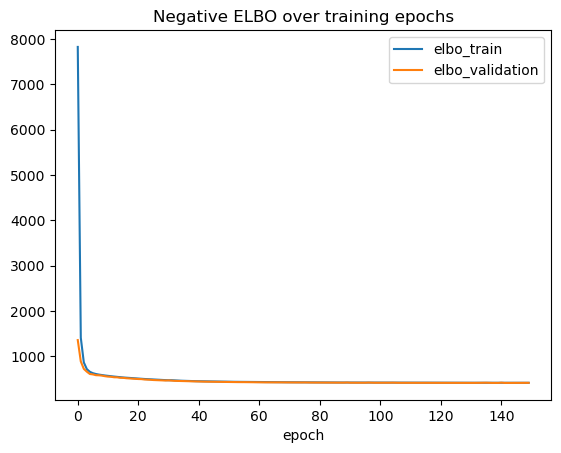

In [17]:
fig, ax = plt.subplots(1, 1)
model.history["elbo_train"].plot(ax=ax, label="train")
model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs")
ax.legend()

In [20]:
# get totalVI's latent dimensions 
influenza_data.mod['filtered_transcriptome'].obsm['totalVI_latent_dims'] = model.get_latent_representation()
rna_normalized, protein_normalized = model.get_normalized_expression()
influenza_data.mod['adt'].layers['adt_normalized'] = protein_normalized
influenza_data.mod['adt'].uns['totalVI_runtime'] = training_duration
influenza_data.mod['filtered_transcriptome'].layers['rna_normalized'] = rna_normalized
influenza_data.mod['filtered_transcriptome'].uns['totalVI_runtime'] = training_duration
influenza_data.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [19]:
# Save the muon object as h5 so we can load it into R
influenza_data.mod['adt'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_adt_influenza.h5ad')
influenza_data.mod['filtered_transcriptome'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_rna_influenza.h5ad')

# NK cell data

In [3]:
# Load the data
nk_ADT = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/ADT_nk.h5ad')
nk_RNA = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/RNA_nk.h5ad')

In [4]:
nk_RNA

AnnData object with n_obs × n_vars = 141140 × 5248
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'Barcode', 'capture', 'hashedDrops.Total', 'hashedDrops.Best', 'hashedDrops.Second', 'hashedDrops.LogFC', 'hashedDrops.LogFC2', 'hashedDrops.Doublet', 'hashedDrops.Confident', 'hash.ID_DropUtil', 'vireo.donor_id', 'vireo.prob_max', 'vireo.prob_doublet', 'vireo.n_vars', 'vireo.best_singlet', 'vireo.best_doublet', 'vireo.doublet_logLikRatio', 'genetic_donor', 'colours.hto_colours', 'colours.genetic_donor_colours', 'colours.capture_colours', 'nCount_ADT', 'nFeature_ADT', 'Day', 'Treatment', 'Day_Treatment', 'log2_rna_libsize', 'log2_adt_libsize'
    uns: 'X_name'

In [5]:
nk_RNA.layers["counts"] = nk_RNA.X.copy()
nk_data = muon.MuData({'rna': nk_RNA, 'adt': nk_ADT})

## Use scanpy to filter highly variable genes
sc.pp.highly_variable_genes(
    adata = nk_data.mod['rna'],
    layer = 'counts', 
    n_top_genes = 4000,
    flavor = 'seurat_v3')
    #batch_key= 'batch')

# Save filtered transcriptome as extra dimension
nk_data.mod['filtered_transcriptome'] = nk_data.mod['rna'][:, nk_data.mod['rna'].var['highly_variable']].copy()
nk_data.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [6]:
nk_data

MuData object with n_obs × n_vars = 141140 × 9295
  3 modalities
    rna:	141140 x 5248
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'Barcode', 'capture', 'hashedDrops.Total', 'hashedDrops.Best', 'hashedDrops.Second', 'hashedDrops.LogFC', 'hashedDrops.LogFC2', 'hashedDrops.Doublet', 'hashedDrops.Confident', 'hash.ID_DropUtil', 'vireo.donor_id', 'vireo.prob_max', 'vireo.prob_doublet', 'vireo.n_vars', 'vireo.best_singlet', 'vireo.best_doublet', 'vireo.doublet_logLikRatio', 'genetic_donor', 'colours.hto_colours', 'colours.genetic_donor_colours', 'colours.capture_colours', 'nCount_ADT', 'nFeature_ADT', 'Day', 'Treatment', 'Day_Treatment', 'log2_rna_libsize', 'log2_adt_libsize'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'X_name', 'hvg'
      layers:	'counts'
    adt:	141140 x 47
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'Barcode', 'capture', 'hashedDrops.Total', 'hashedDrops.Best', 'hashedDrops.Second', 'hashedDrops.LogFC', 'hashedDrops.LogFC2', 'hashedDrops.Doublet', 'hashedDrops.Confident', 'hash.ID_DropUtil', 'vireo.donor_id', 'vireo.prob_max', 'vireo.prob_doublet', 'vireo.n_vars', 'vireo.best_singlet', 'vireo.best_doublet', 'vireo.doublet_logLikRatio', 'genetic_donor', 'colours.hto_colours', 'colours.genetic_donor_colours', 'colours.capture_colours', 'nCount_ADT', 'nFeature_ADT', 'Day', 'Treatment', 'Day_Treatment', 'log2_rna_libsize', 'log2_adt_libsize'
      uns:	'X_name'
    filtered_transcriptome:	141140 x 4000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'Barcode', 'capture', 'hashedDrops.Total', 'hashedDrops.Best', 'hashedDrops.Second', 'hashedDrops.LogFC', 'hashedDrops.LogFC2', 'hashedDrops.Doublet', 'hashedDrops.Confident', 'hash.ID_DropUtil', 'vireo.donor_id', 'vireo.prob_max', 'vireo.prob_doublet', 'vireo.n_vars', 'vireo.best_singlet', 'vireo.best_doublet', 'vireo.doublet_logLikRatio', 'genetic_donor', 'colours.hto_colours', 'colours.genetic_donor_colours', 'colours.capture_colours', 'nCount_ADT', 'nFeature_ADT', 'Day', 'Treatment', 'Day_Treatment', 'log2_rna_libsize', 'log2_adt_libsize'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'X_name', 'hvg'
      layers:	'counts'

In [7]:
nk_data.mod['adt'].X = nk_data.mod['adt'].X.toarray()
# Convert to RNA csr matrix for faster training
nk_data.mod['rna'].X = nk_data.mod['rna'].X.tocsr()
nk_data.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [8]:
nk_data['adt']

AnnData object with n_obs × n_vars = 141140 × 47
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'Barcode', 'capture', 'hashedDrops.Total', 'hashedDrops.Best', 'hashedDrops.Second', 'hashedDrops.LogFC', 'hashedDrops.LogFC2', 'hashedDrops.Doublet', 'hashedDrops.Confident', 'hash.ID_DropUtil', 'vireo.donor_id', 'vireo.prob_max', 'vireo.prob_doublet', 'vireo.n_vars', 'vireo.best_singlet', 'vireo.best_doublet', 'vireo.doublet_logLikRatio', 'genetic_donor', 'colours.hto_colours', 'colours.genetic_donor_colours', 'colours.capture_colours', 'nCount_ADT', 'nFeature_ADT', 'Day', 'Treatment', 'Day_Treatment', 'log2_rna_libsize', 'log2_adt_libsize'
    uns: 'X_name'

In [9]:
scvi.model.TOTALVI.setup_mudata(
    mdata = nk_data,
    rna_layer = 'counts',
    protein_layer= None,
    batch_key= 'capture' ,
    modalities= {"rna_layer":'filtered_transcriptome',
                 'protein_layer':'adt',
                 'batch_key':'rna'})

model = scvi.model.TOTALVI(nk_data, latent_distribution= 'normal')

INFO     Computing empirical prior initialization for protein background.                                          


/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.


In [10]:
start_time = time.time()
model.train()
end_time = time.time()
training_duration = end_time - start_time

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 57/57: 100%|██████████| 57/57 [1:42:03<00:00, 107.49s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.47e+3]

`Trainer.fit` stopped: `max_epochs=57` reached.


Epoch 57/57: 100%|██████████| 57/57 [1:42:03<00:00, 107.42s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.47e+3]


In [11]:
# get totalVI's latent dimensions 
nk_data.mod['filtered_transcriptome'].obsm['totalVI_latent_dims'] = model.get_latent_representation()
rna_normalized, protein_normalized = model.get_normalized_expression()
nk_data.mod['adt'].layers['adt_normalized'] = protein_normalized
nk_data.mod['adt'].uns['totalVI_runtime'] = training_duration
nk_data.mod['filtered_transcriptome'].layers['rna_normalized'] = rna_normalized
nk_data.mod['filtered_transcriptome'].uns['totalVI_runtime'] = training_duration
nk_data.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [12]:
# Save the muon object as h5 so we can load it into R
nk_data.mod['adt'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_adt_nk.h5ad')
nk_data.mod['filtered_transcriptome'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_rna_nk.h5ad')